<a href="https://colab.research.google.com/github/reibek/progn-semestral-work/blob/main/Progonstics_Semestral_work_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import warnings
import itertools
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Enviroment settings.

In [2]:
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

# Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/FRI/PROGN/SK_TAVG_Trend.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data insight

Data contains an extracted regional summary of land-surface temperature results produced by the Berkeley Earth averaging method for the region of **Slovakia**.

Temperatures are in Celsius and reported as anomalies relative to the January 1951 - December 1980 average. Uncertainties represent the 95% confidence interval for statistical noise and spatial undersampling effects.

This analysis was run on 06-Jan-2021 15:35:34

The current region is characterized by: 
*   Name: Slovakia
*   Latitude Range: 47.75 to 49.60
*   Longitude Range: 16.84 to 22.54
*   Area: 48377.12 km^2
*   Percent of global land area: 0.033 %
*   Approximate number of temperature stations: 46
*   Approximate number of monthly obeservations: 22170

Estimated January 1951 - December 1980 absolute temperature (°C): 7.52 +/- 0.45

Estimated Jan 1951-Dec 1980 monthly absolute temperature (C):

|     | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
|     | -3.70 | -1.77 | 2.20 | 7.45 | 12.39 | 16.02 | 17.40 | 16.93 | 13.27 | 8.21 | 3.18 | -1.36 |
| +/- | 0.58 | 0.50 | 0.48 | 0.53 | 0.53 | 0.50 | 0.49 | 0.48 | 0.45 | 0.47 | 0.50 | 0.56 |

In [4]:
monthly_abs_temperature = [-3.70, -1.77, 2.20, 7.45, 12.39, 16.02, 17.40, 16.93, 13.27, 8.21, 3.18, -1.36]

We will run a basic analysis of our dataset including preview, NaN values summary and dataset info.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  3252 non-null   int64  
 1   Month                 3252 non-null   int64  
 2   MonthlyAnomaly        3251 non-null   float64
 3   MonthlyAnomalyUnc     3251 non-null   float64
 4   AnnualAnomaly         3233 non-null   float64
 5   AnnuralAnomalyUnc     3233 non-null   float64
 6   FiveYearAnomaly       3160 non-null   float64
 7   FiveYearAnomalyUnc    3160 non-null   float64
 8   TenYearAnomaly        3100 non-null   float64
 9   TenYearAnomalyUnc     3100 non-null   float64
 10  TwentyYearAnomaly     2980 non-null   float64
 11  TwentyYearAnomalyUnc  2980 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 305.0 KB


In [6]:
df.describe()

,Year,Month,MonthlyAnomaly,MonthlyAnomalyUnc,AnnualAnomaly,AnnuralAnomalyUnc,FiveYearAnomaly,FiveYearAnomalyUnc,TenYearAnomaly,TenYearAnomalyUnc,TwentyYearAnomaly,TwentyYearAnomalyUnc
count,3252.00000,3252.000000,3251.000000,3251.000000,3233.000000,3233.000000,3160.000000,3160.000000,3100.000000,3100.000000,2980.000000,2980.000000
mean,1885.00000,6.500000,-0.156355,1.355326,-0.159859,0.580594,-0.169064,0.383882,-0.184185,0.332458,-0.203371,0.275071
std,78.24246,3.452583,1.940423,1.572614,0.831639,0.605212,0.542940,0.369598,0.460844,0.306877,0.383514,0.238611
min,1750.00000,1.000000,-10.527000,0.071000,-2.738000,0.033000,-1.300000,0.027000,-0.987000,0.029000,-0.755000,0.016000
25%,1817.00000,3.750000,-1.266000,0.302500,-0.711000,0.127000,-0.529000,0.078000,-0.502250,0.070000,-0.468000,0.070000
50%,1885.00000,6.500000,-0.054000,0.601000,-0.179000,0.299000,-0.261500,0.208000,-0.266000,0.182000,-0.285000,0.157500
75%,1953.00000,9.250000,1.111500,1.905500,0.350000,0.888000,0.055500,0.585500,-0.004750,0.512000,-0.038750,0.455000
max,2020.00000,12.000000,6.090000,10.899000,2.862000,4.281000,1.894000,1.584000,1.676000,1.290000,1.314000,1.019000


In [7]:
df.head()

,Year,Month,MonthlyAnomaly,MonthlyAnomalyUnc,AnnualAnomaly,AnnuralAnomalyUnc,FiveYearAnomaly,FiveYearAnomalyUnc,TenYearAnomaly,TenYearAnomalyUnc,TwentyYearAnomaly,TwentyYearAnomalyUnc
0,1750,1,-0.306,1.732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1750,2,0.277,2.294,-0.245,0.940,NaN,NaN,NaN,NaN,NaN,NaN
2,1750,3,2.140,2.689,-0.237,0.950,NaN,NaN,NaN,NaN,NaN,NaN
3,1750,4,0.413,1.539,-0.233,0.939,NaN,NaN,NaN,NaN,NaN,NaN
4,1750,5,-1.227,1.544,-0.496,0.932,NaN,NaN,NaN,NaN,NaN,NaN


First, we will make dataset index to be datetime type from columns `Month` and `Year`.

In [8]:
cols = ['Year', 'Month']
df['Date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df['Date']=pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.asfreq('MS') # Month Start

Since we will focus on monthly data, we can drop other columns.

In [9]:
df.drop(['Month', 'Year', 'MonthlyAnomalyUnc', 'AnnualAnomaly', 'AnnuralAnomalyUnc', 'FiveYearAnomaly', 'FiveYearAnomalyUnc', 'TenYearAnomaly', 'TenYearAnomalyUnc', 'TwentyYearAnomaly', 'TwentyYearAnomalyUnc'], 
        axis='columns', inplace=True)

In [10]:
df.isnull().sum()

MonthlyAnomaly    1
dtype: int64

Now, we will look at NaN values. We can see, that there's only one NaN value in our data. It will be replaced using mehod `bfill`, what means, that we replace value by it's previous value.

In [11]:
df.fillna(method='bfill', inplace=True)

Next, we will prepare also data with absolute monthly temperatures, not only anomalities.

In [12]:
df['MonthlyAverage'] = 0.0

for i in range(0, df.MonthlyAnomaly.size):
    df.MonthlyAverage[i] = df.MonthlyAnomaly[i] + monthly_abs_temperature[i % 12]

Let's plot our data.

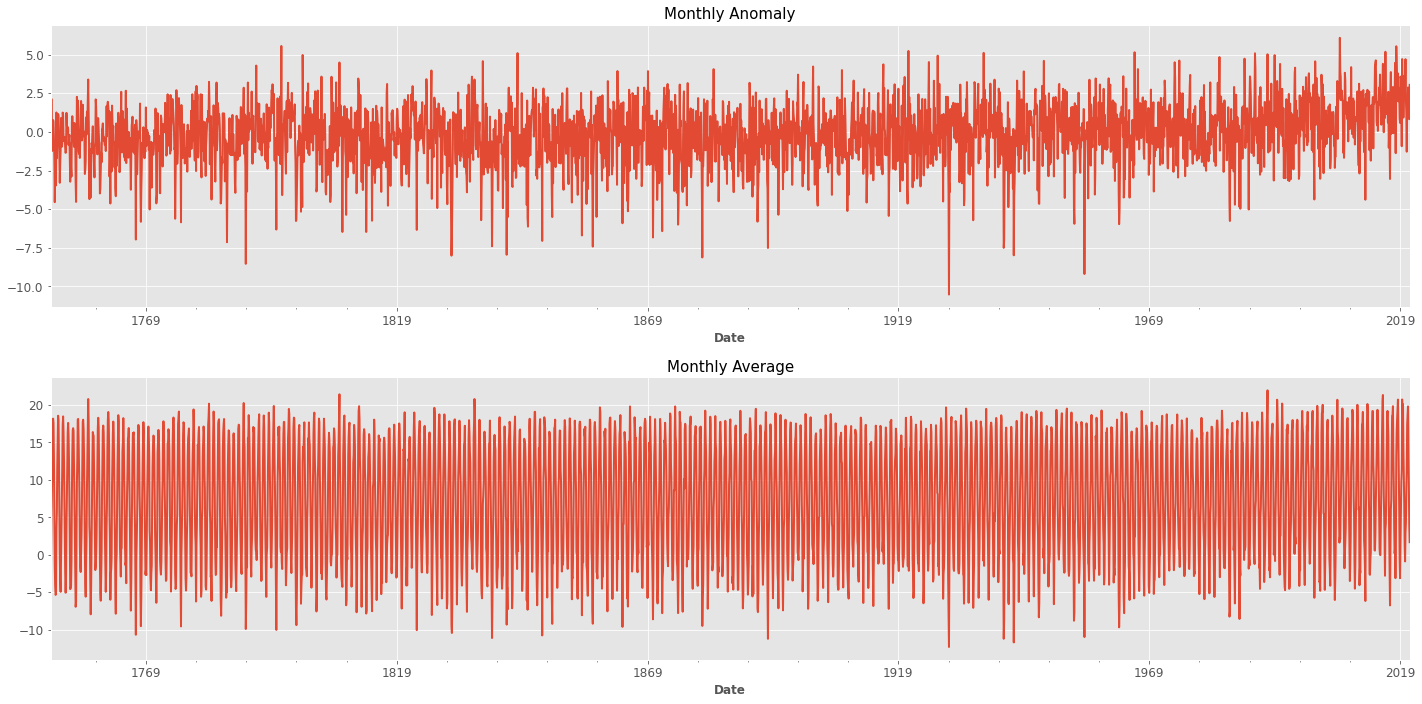

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.title('Monthly Anomaly',fontsize=15)
df.MonthlyAnomaly.plot()

plt.subplot(2,1,2)
plt.title('Monthly Average',fontsize=15)
df.MonthlyAverage.plot()

plt.tight_layout()

We can also closely inspect different decades.

In [14]:
def get_timeseries(timeseries, year_from, year_to):
    return timeseries[datetime.datetime(year_from, 1, 1):datetime.datetime(year_to - 1, 12, 31)]

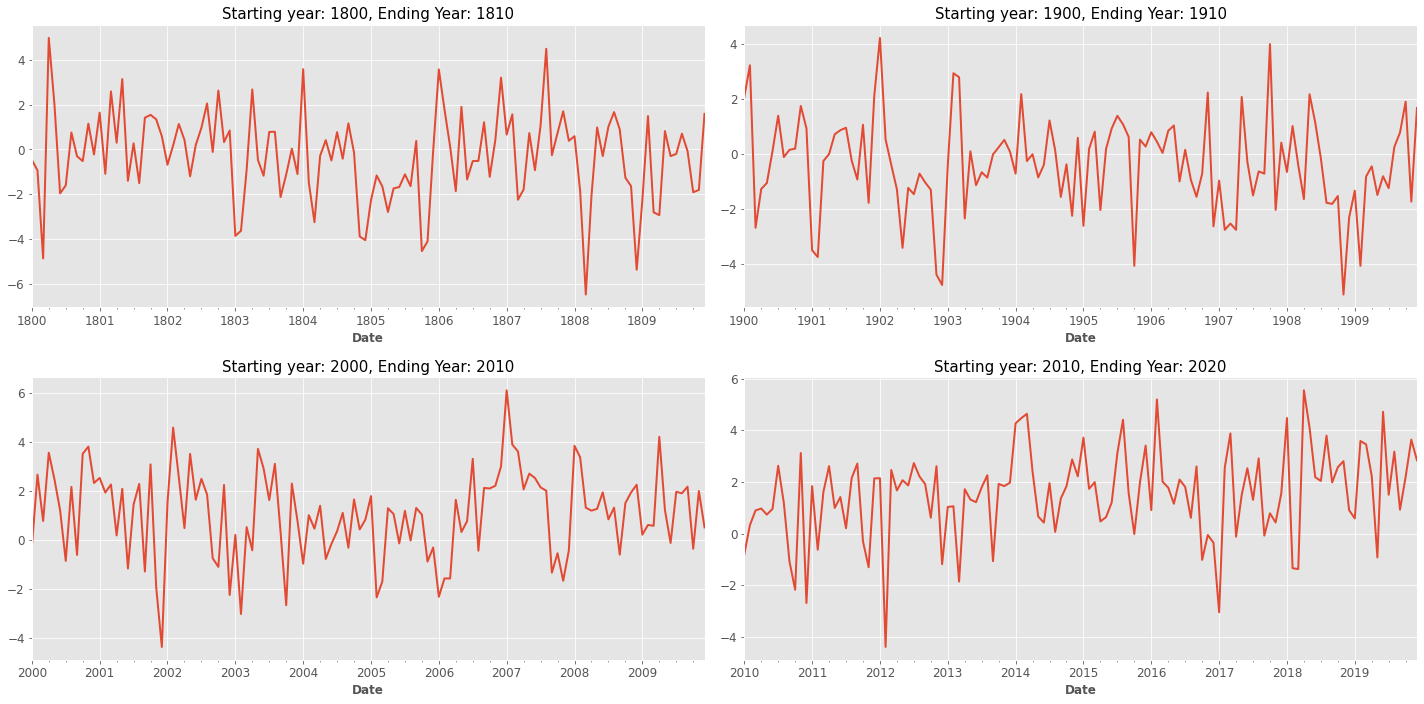

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.title('Starting year: 1800, Ending Year: 1810',fontsize=15)
get_timeseries(df.MonthlyAnomaly, 1800, 1810).plot()
plt.subplot(2,2,2)
plt.title('Starting year: 1900, Ending Year: 1910',fontsize=15)
get_timeseries(df.MonthlyAnomaly, 1900, 1910).plot()
plt.subplot(2,2,3)
plt.title('Starting year: 2000, Ending Year: 2010',fontsize=15)
get_timeseries(df.MonthlyAnomaly, 2000, 2010).plot()
plt.subplot(2,2,4)
plt.title('Starting year: 2010, Ending Year: 2020',fontsize=15)
get_timeseries(df.MonthlyAnomaly, 2010, 2020).plot()
plt.tight_layout()

We are interested in predicting future progress of temperature anomalities, so now we will focus on last decade from 2010 to 2020.

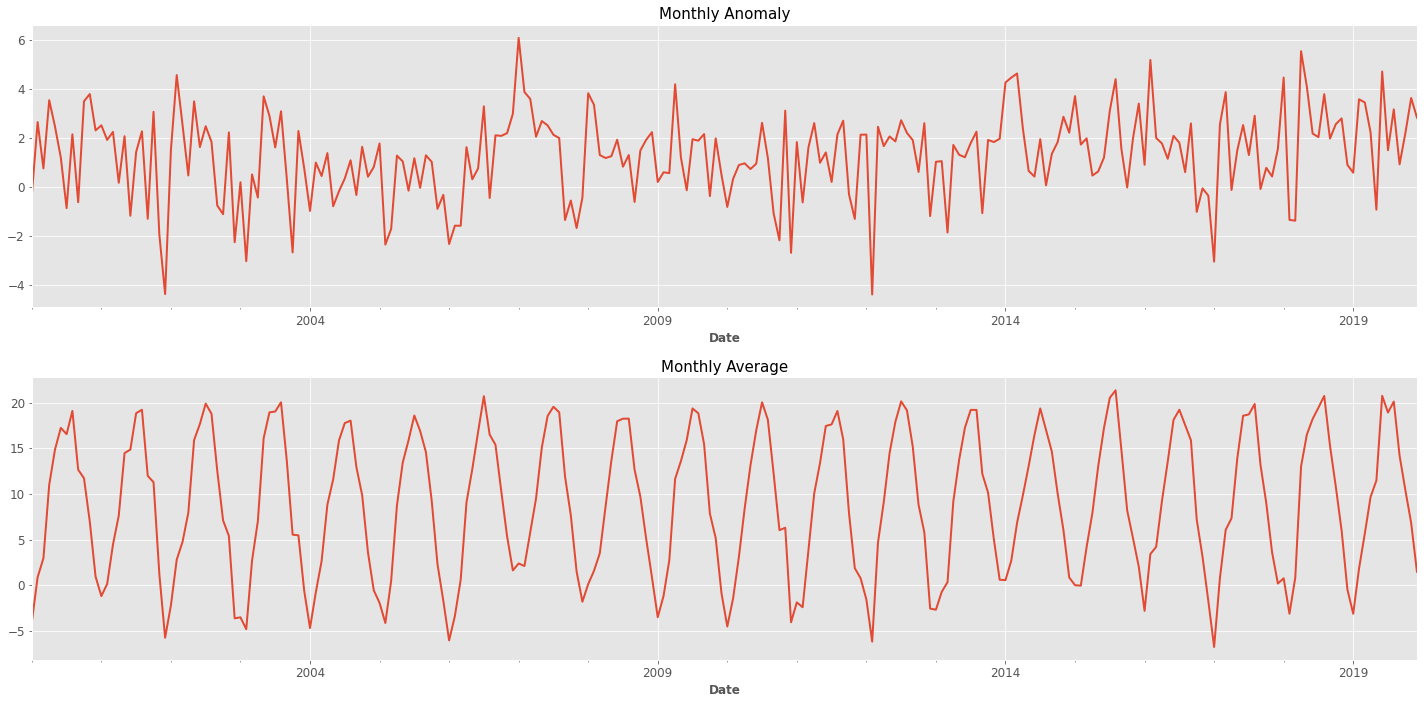

In [16]:
df_2000 = get_timeseries(df, 2000, 2020)

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.title('Monthly Anomaly',fontsize=15)
df_2000.MonthlyAnomaly.plot()

plt.subplot(2,1,2)
plt.title('Monthly Average',fontsize=15)
df_2000.MonthlyAverage.plot()

plt.tight_layout()

# Analysis

## Seasonal decompose

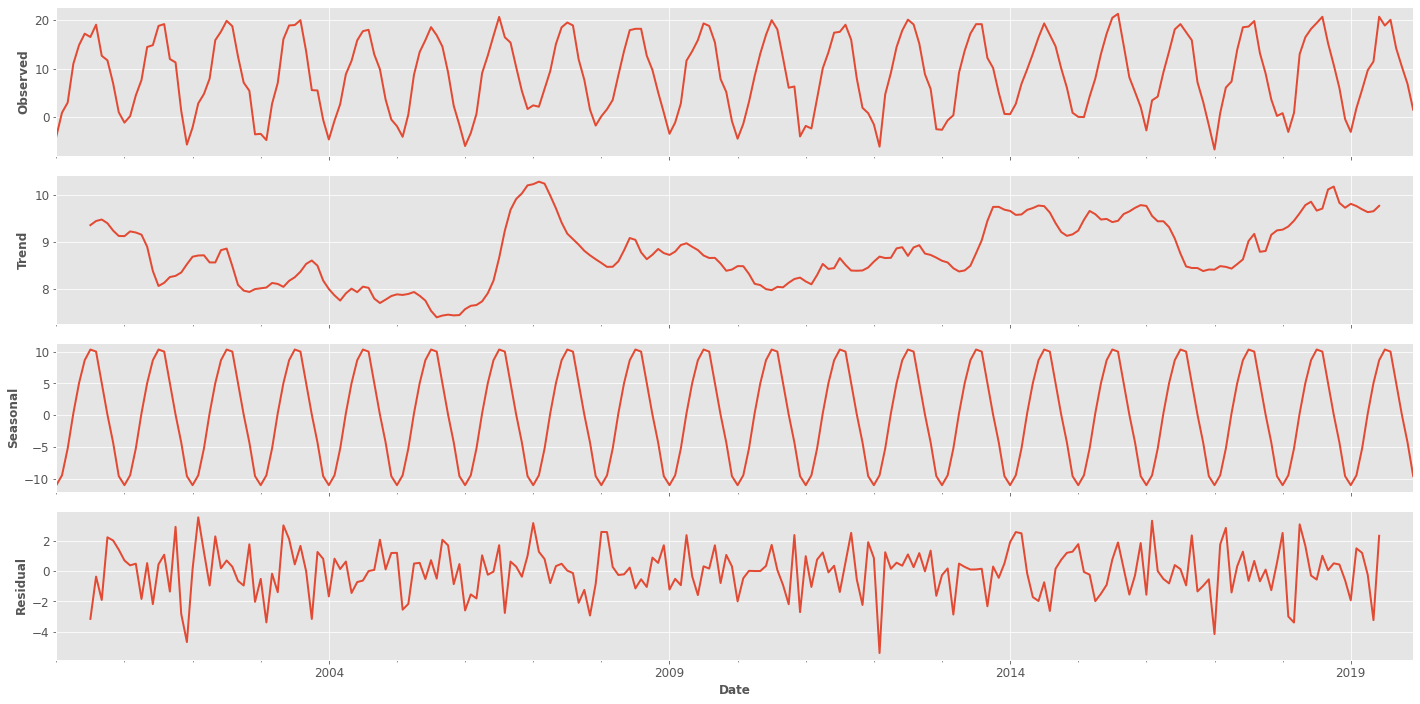

In [18]:
plt.rcParams['figure.figsize'] = [20, 10]
seasonal_decompose(df_2000.MonthlyAverage).plot();

## Stationarity

Before we will model our data, we have to mak sure, that our data are stationary. We can test our data with **ADF** and **KPSS** tests.

### ADF
The Augmented Dickey Fuller Test (**ADF**) is unit root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.

The Augmented Dickey-Fuller test can be used with serial correlation. The ADF test can handle more complex models than the Dickey-Fuller test, and it is also more powerful. That said, it should be used with caution because—like most unit root tests—it has a relatively high Type I error rate.

Hypotheses:
* The null hypothesis for this test is that there is a unit root.
* The alternate hypothesis differs slightly according to which equation you’re using. The basic alternate is that the time series is stationary (or trend-stationary).

Source: [https://www.statisticshowto.com/adf-augmented-dickey-fuller-test/](https://www.statisticshowto.com/adf-augmented-dickey-fuller-test/)

### KPSS
The Kwiatkowski–Phillips–Schmidt–Shin (**KPSS**) test figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root. A stationary time series is one where statistical properties — like the mean and variance — are constant over time.

Hypotheses:
* The null hypothesis for the test is that the data is stationary.
* The alternate hypothesis for the test is that the data is not stationary.

Source: [https://www.statisticshowto.com/kpss-test/](https://www.statisticshowto.com/kpss-test/)

In [19]:
from statsmodels.tsa.stattools import kpss

def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, label='Original')
    mean = plt.plot(rolling_mean, color='blue', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print ('Results of ADF Test:')
    print('ADF Statistic: \t{}'.format(result[0]))
    print('p-value: \t{}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: \t{}'.format(key, value))

    # KPSS test:
    kpsstest = kpss(timeseries, regression='c')
    print ('\nResults of KPSS Test:')
    print('KPSS Statistic: {}'.format(kpsstest[0]))
    print('p-value: \t{}'.format(kpsstest[1]))
    print('Lags Used: \t{}'.format(kpsstest[2]))
    print('Critical Values:')
    for key,value in kpsstest[3].items():
        print('\t{}: \t{}'.format(key, value))

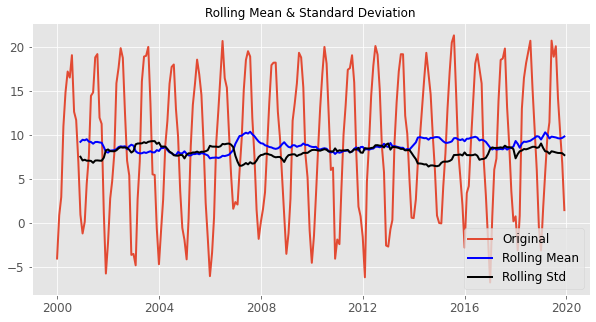

Results of ADF Test:
ADF Statistic: 	-2.9862450702023375
p-value: 	0.03619905753883359
Critical Values:
	1%: 	-3.4593607492757554
	5%: 	-2.8743015807562924
	10%: 	-2.5735714042782396

Results of KPSS Test:
KPSS Statistic: 0.12125333062799419
p-value: 	0.1
Lags Used: 	15
Critical Values:
	10%: 	0.347
	5%: 	0.463
	2.5%: 	0.574
	1%: 	0.739


In [20]:
plt.rcParams['figure.figsize'] = [10, 5]
get_stationarity(df_2000.MonthlyAverage)

From results we can see, that both test evaluated data as **stationary**.

## Correlograms

In [22]:
def corr_plot(y, lags=30, figsize=(20, 5)):

    fig = plt.figure(figsize=figsize)
    layout = (1, 2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))

    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

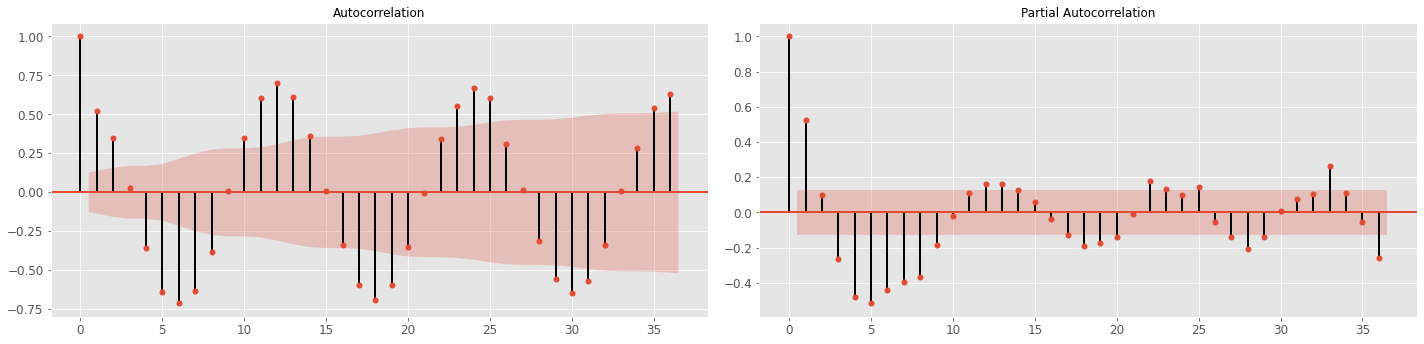

In [75]:
corr_plot(df_2000.MonthlyAverage, lags=36)

# SARIMA model

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Source: [https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)

We will find best SARIMA model by changig parameters in trend elements `(p,d,q)` and also in seasonal elements `(P,D,Q)m` except for parameter `m` in range from 0 to 2 (including) for parameters `p(P)` and `q(Q)` and in range from 0 to 1 (including) for parameter `d(D)`.

In [29]:
p = q = range(0, 3)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [44]:
aic_dict = dict()

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_2000.MonthlyAverage,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            aic_dict.update({(param,param_seasonal):results.aic})
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1857.2097487457233
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1542.0134736772725
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1342.3706393044217
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1062.62433435803
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:879.7208061925774
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:840.7418407261175
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1067.5511641229955
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:938.8587958727784
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:892.906265974174
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:946.2906043371232
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:892.2288676915373
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:837.5908033997176
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:948.2010587420302
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:894.3558181529379
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:886.8178460428462
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:876.0473440273064
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:841.4709812556405
ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:839.6918185093011
ARIMA(0,

Now we sort our models based on AIC metric and take a look for best 10 models.

In [64]:
def first_n_dict(dict, n=10):
    i = 1
    for (key, value) in sorted(dict.items(), key=lambda x: x[1]):
        print(f'{i}: \t{key} - AIC: {value}')
        
        if i == n:
            break
        else:
            i += 1

first_n_dict(aic_dict, 10)

1: 	((1, 1, 2), (2, 1, 2, 12)) - AIC: 813.1169784513908
2: 	((1, 0, 2), (2, 1, 2, 12)) - AIC: 814.7511913683387
3: 	((2, 1, 2), (2, 1, 2, 12)) - AIC: 815.0076303942888
4: 	((1, 1, 2), (0, 1, 2, 12)) - AIC: 815.0515589305309
5: 	((0, 1, 2), (0, 1, 2, 12)) - AIC: 815.2398333431483
6: 	((0, 1, 2), (2, 1, 2, 12)) - AIC: 816.11074636786
7: 	((1, 0, 1), (2, 1, 2, 12)) - AIC: 816.7408390545313
8: 	((0, 1, 2), (1, 1, 2, 12)) - AIC: 816.9084100882023
9: 	((2, 0, 2), (2, 1, 2, 12)) - AIC: 817.2279530842395
10: 	((2, 1, 2), (2, 1, 1, 12)) - AIC: 817.6332863036848


As we can see, all of first 10 models have very similar AIC metric, so we can choose model, that has least used parameters and that is **SARIMA (0, 1, 2) x (0, 1, 2)12** 

In [49]:
mod = sm.tsa.statespace.SARIMAX(df_2000.MonthlyAverage,order=(0,1,2),seasonal_order=(0,1,2,12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()

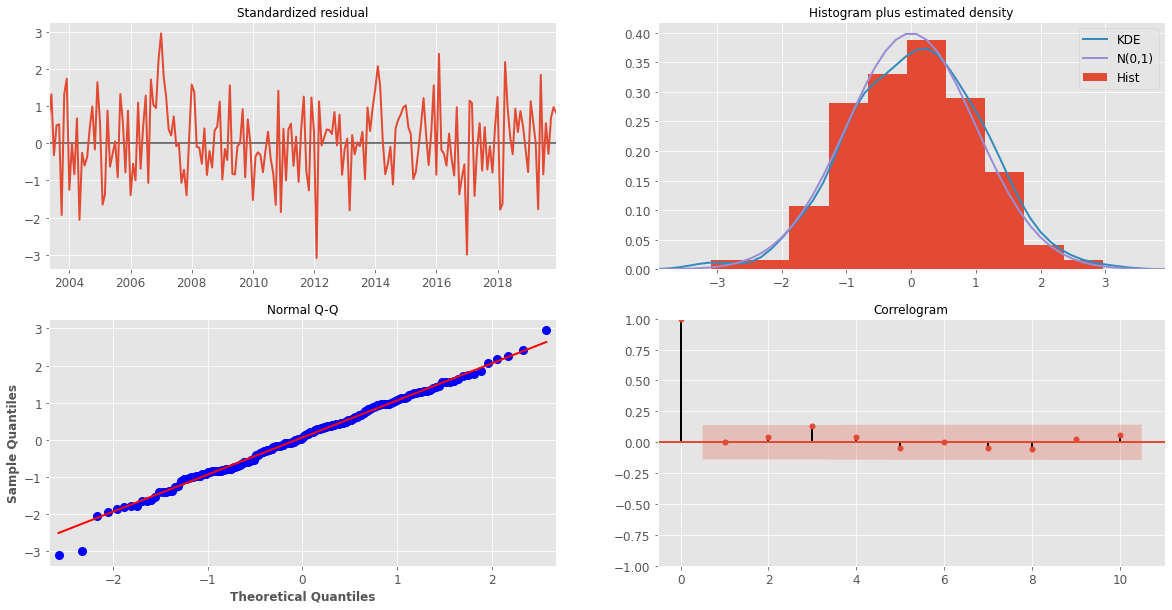

In [95]:
plt.rcParams['figure.figsize'] = [20, 10]
results.plot_diagnostics()
plt.show()

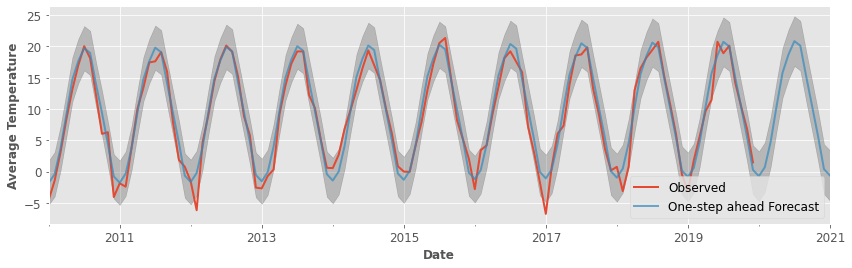

In [94]:
pred = results.get_prediction(start=pd.to_datetime('2010-01-01'), end=pd.to_datetime('2021-01-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = df_2000.MonthlyAverage['2010':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Average Temperature')
plt.legend()
plt.show()

In [93]:
y_forecasted = pred.predicted_mean[:'2019']
y_truth = df_2000.MonthlyAverage['2010':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

y_forecasted.describe()
y_truth.describe()

The Mean Squared Error is 3.04
The Root Mean Squared Error is 1.74


count    120.000000
mean       9.045025
std        7.755843
min       -6.745000
25%        2.004500
50%        9.143500
75%       16.456750
max       21.335000
Name: MonthlyAverage, dtype: float64